In [2]:
import keras
from keras.layers import Flatten,Dense
from keras.models import Sequential , Model
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
labels = ['PNEUMONIA', 'NORMAL','COVID','TUBERCULOSIS']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                new_img = cv2.imread(os.path.join(path,img))
                resized_img = cv2.resize(new_img,(img_size,img_size))
                data.append([resized_img,class_num])
            except:
                continue
    return np.array(data)      
    

In [4]:
train = get_data('E:/Final Year Project Report/Chest X-Ray Images/chest_xray/train')
test = get_data('E:/Final Year Project Report/Chest X-Ray Images/chest_xray/test')


C:\Users\Home\anaconda3\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [5]:
X_train = []
y_train = []

X_test = []
y_test = []

for img,label in train:
    X_train.append(img)
    y_train.append(label)
    
for img,label in test:
    X_test.append(img)
    y_test.append(label)

In [7]:
X_train[0].shape

(224, 224, 3)

In [14]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=[224,224]+ [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 120s 2us/step


In [15]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [16]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [18]:
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
from glob import glob

folders = glob('E:/Final Year Project Report/Chest X-Ray Images/chest_xray/train/*')
len(folders)

4

In [29]:

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [30]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [32]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('E:/Final Year Project Report/Chest X-Ray Images/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 10948 images belonging to 4 classes.


In [33]:
test_set = test_datagen.flow_from_directory('E:/Final Year Project Report/Chest X-Ray Images/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1424 images belonging to 4 classes.


In [34]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
343/343 [==============================] - 5440s 16s/step - loss: 0.5008 - accuracy: 0.8139 - val_loss: 0.2803 - val_accuracy: 0.8954
Epoch 2/5
343/343 [==============================] - 5018s 15s/step - loss: 0.1617 - accuracy: 0.9428 - val_loss: 0.2361 - val_accuracy: 0.9213
Epoch 3/5
343/343 [==============================] - 4560s 13s/step - loss: 0.1385 - accuracy: 0.9512 - val_loss: 0.2731 - val_accuracy: 0.9199
Epoch 4/5
343/343 [==============================] - 4581s 13s/step - loss: 0.1118 - accuracy: 0.9603 - val_loss: 0.2865 - val_accuracy: 0.9129
Epoch 5/5
343/343 [==============================] - 5709s 17s/step - loss: 0.1130 - accuracy: 0.9610 - val_loss: 0.2719 - val_accuracy: 0.9312


In [36]:
model.evaluate(test_set)

45/45 [==============================] - 681s 15s/step - loss: 0.2719 - accuracy: 0.9312


[0.27191683650016785, 0.9311797618865967]

In [37]:
model.save('VGG16_Model.h5')

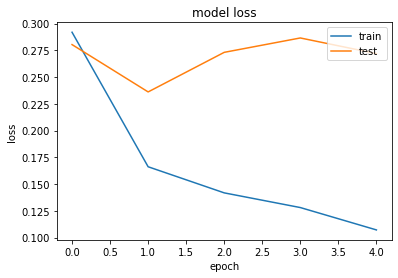

In [38]:
# plotting training set and validation test 
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

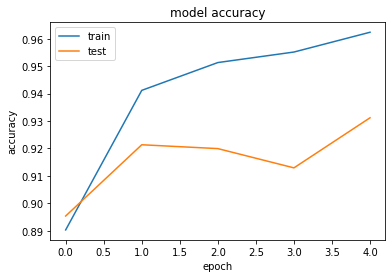

In [39]:
# plotting training set and validation test 
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)','Covid (Class 2)','Tuberculosis (Class 3)']))

AttributeError: 'Functional' object has no attribute 'predict_classes'

In [ ]:
prediction = model.predict(test_set)